<a href="https://colab.research.google.com/github/AlvinChiew/MachineLearning/blob/main/Sklearn_Regression_Ridge.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

- Motivations
    - Create bias to overcome data-overfitting, espcially when data size is small
        - due to bias, variance drops significantly
        - better long term prediction
    - Solve dataset with high dimensionality but insufficient data problem
    - applies when all/most variables in dataset is useful


- Minimize MSE + alpha (or lambda) x slope^2 --> ridge regression penalty
    - adjust slope for min result
    - causing prediction to be less/more sensitive to a feature
    - lower lambda, steeper slope, higher sensitivity
        - use 10-fold cross validation to determine lambda with lowest variance

- Also applicable to
    - discrete feature (e.g. high and low diet vs size)
        - slope = diet difference in mean size from both diet
        - higher lambda,  bias towards smaller diet difference, less sensitivity
    - logistics regression (weight vs obsese or not obese)
        - max likelihood
        - higher lambda, less sensitive to weight
    - multidimensional
        -  ridge regression penalty = sum of (dimension slope)^2


# Import Modules


In [1]:
!wget https://raw.githubusercontent.com/AlvinChiew/MachineLearning/main/raw_data/gen_data.py

--2020-12-27 16:57:25--  https://raw.githubusercontent.com/AlvinChiew/MachineLearning/main/raw_data/gen_data.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1494 (1.5K) [text/plain]
Saving to: ‘gen_data.py.2’

gen_data.py.2       100%[===================>]   1.46K  --.-KB/s    in 0s      

2020-12-27 16:57:25 (29.4 MB/s) - ‘gen_data.py.2’ saved [1494/1494]



In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge

from gen_data import load_extended_boston       # MinMaxScaled, derived statistical features (binomial features)    # https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PolynomialFeatures.html

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.datasets.samples_generator module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.datasets. Anything that cannot be imported from sklearn.datasets is now part of the private API.
  warnings.warn(message, FutureWarning)


In [3]:
from sklearn.datasets import load_boston
print(load_boston().DESCR)

.. _boston_dataset:

Boston house prices dataset
---------------------------

**Data Set Characteristics:**  

    :Number of Instances: 506 

    :Number of Attributes: 13 numeric/categorical predictive. Median Value (attribute 14) is usually the target.

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pu

In [4]:
load_boston().data.shape

(506, 13)

# Load Data

In [5]:
X, y = load_extended_boston()
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

# Train Model

In [6]:
alpha_range      = np.linspace(0.025,5, 200)
train_scores = [] 
test_scores  = [] 
coefs       = []

for alpha in alpha_range:
    model = Ridge(alpha=alpha).fit(X_train, y_train)
    train_scores.append( model.score( X_train, y_train) )
    test_scores.append ( model.score( X_test,  y_test ) )
    coefs.append(model.coef_)

# Evaluation

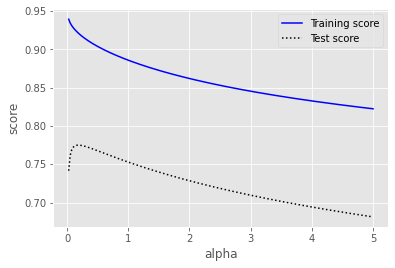

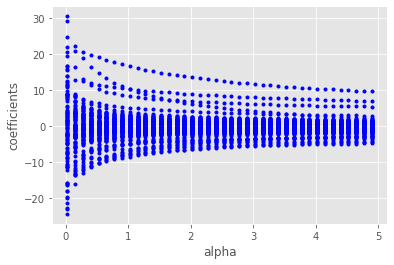

In [7]:
 def plot_ridge_result(alpha_range, train_scores,test_scores, coefs):
    plt.style.use('ggplot')
    plt.figure(1)
    plt.plot( alpha_range, train_scores, 'b-')
    plt.plot( alpha_range, test_scores,  'k:')
    plt.legend(['Training score', 'Test score'])
    plt.xlabel('alpha')
    plt.ylabel('score')

    plt.figure(2)
    for a,c in zip(alpha_range[::5], coefs[::5]):
        plt.plot(a*np.ones_like(c), c, 'b.')
    plt.xlabel('alpha')
    plt.ylabel('coefficients')
    plt.show()

plot_ridge_result(alpha_range, train_scores,test_scores, coefs)
# Overall test score is quite low although high training score. 
# regularization doesn't seem to resolve overfitting issue. 
# Probably there is significant gap between train set and test set.
# Try cross-validation: https://win-vector.com/2019/11/12/when-cross-validation-is-more-powerful-than-regularization/#:~:text=Regularization%20is%20a%20way%20of,deep%20learning%2C%20node%20weights).&text=Cross%2Dvalidation%20is%20a%20way,data%20in%20nested%20model%20situations.


# Extra: Cross-Validation - kfold

In [8]:
from sklearn.model_selection import cross_val_score

In [9]:
scores = cross_val_score(model, X, y,
                         scoring='r2',              # Score by R^2
                         cv=5)                      # 5 folds cross validation
scores
# Some yielded better result while some are extremely terrible. 
# Seems like hypothesis is right. Some corner cases were isolated from train set earlier on.
# train test split is not randomized appropriately. Can try to change random state and test again

array([0.75928379, 0.76105059, 0.65857207, 0.29131513, 0.43470853])

In [10]:
from sklearn.linear_model import RidgeCV

In [11]:
model_cv = RidgeCV(alpha_range, cv=5).fit(X, y)
print(f'Score: {model_cv.score(X, y)}')
print(f'alpha: {model_cv.alpha_}')

# Need more data to support train test split. Or reduce dimension.

Score: 0.864762505438053
alpha: 1.0499999999999998


# Extra: feature selection - reduce D

In [12]:
import pandas as pd 

from sklearn.feature_selection import RFE       # recurssive feature elimination
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV

In [13]:
X.shape

(506, 104)

In [14]:
folds = KFold(n_splits = 5)
hyper_params = [{'n_features_to_select': list(range(5, 16))}]   # n_feature = 5 to 15
rfe = RFE(model)

model_rfe = GridSearchCV(estimator = rfe, 
                        param_grid = hyper_params, 
                        scoring= 'r2', 
                        cv = folds, 
                        verbose = 1,
                        return_train_score=True)      
model_rfe.fit(X, y)         
# speculate that test set contains corner case which are not contained in train set. 
# Applies all data then use train test split

Fitting 5 folds for each of 11 candidates, totalling 55 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  55 out of  55 | elapsed:   12.4s finished


GridSearchCV(cv=KFold(n_splits=5, random_state=None, shuffle=False),
             error_score=nan,
             estimator=RFE(estimator=Ridge(alpha=5.0, copy_X=True,
                                           fit_intercept=True, max_iter=None,
                                           normalize=False, random_state=None,
                                           solver='auto', tol=0.001),
                           n_features_to_select=None, step=1, verbose=0),
             iid='deprecated', n_jobs=None,
             param_grid=[{'n_features_to_select': [5, 6, 7, 8, 9, 10, 11, 12,
                                                   13, 14, 15]}],
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
             scoring='r2', verbose=1)

In [29]:
rfe_result = pd.DataFrame(model_rfe.cv_results_)
rfe_result[rfe_result['rank_test_score'] == 1][['param_n_features_to_select','split0_test_score','split1_test_score','split2_test_score','split3_test_score','split4_test_score','mean_test_score','split0_train_score','split1_train_score','split2_train_score','split3_train_score','split4_train_score','mean_train_score']].transpose()
# Seems like result is not improved.

,7
param_n_features_to_select,12
split0_test_score,0.756219
split1_test_score,0.754497
split2_test_score,0.626821
split3_test_score,0.243499
split4_test_score,0.411864
mean_test_score,0.55858
split0_train_score,0.760013
split1_train_score,0.733648
split2_train_score,0.687895


# Extra: train test split ver2

In [16]:
np.sort(y_test)

array([ 5.6,  7.4,  8.3,  8.4,  8.8,  9.7, 10.2, 10.4, 10.5, 11.8, 11.9,
       12.3, 13.3, 13.4, 13.8, 13.8, 14.1, 14.5, 14.6, 14.9, 15. , 15. ,
       15.2, 15.6, 15.6, 16.1, 16.5, 16.5, 16.8, 17. , 17.1, 17.1, 17.2,
       17.2, 17.2, 18.3, 18.6, 18.6, 18.7, 18.7, 18.7, 18.8, 18.9, 19.1,
       19.3, 19.4, 19.4, 19.6, 19.8, 19.8, 19.9, 20. , 20. , 20. , 20.1,
       20.1, 20.3, 20.3, 20.4, 20.4, 20.5, 20.6, 20.6, 21. , 21. , 21.2,
       21.2, 21.4, 21.4, 21.6, 21.7, 21.7, 21.7, 21.9, 21.9, 22. , 22.6,
       22.6, 22.6, 22.9, 23. , 23. , 23. , 23. , 23.1, 23.1, 23.2, 23.3,
       23.3, 23.5, 23.6, 23.7, 23.8, 23.9, 24.3, 24.3, 24.4, 24.4, 24.7,
       24.8, 26.4, 26.7, 27.1, 27.5, 27.5, 27.9, 28.1, 29. , 29.1, 29.4,
       29.8, 30.5, 31.2, 31.5, 33.1, 33.3, 33.4, 38.7, 41.3, 42.8, 44.8,
       48.3, 50. , 50. , 50. , 50. , 50. ])

In [17]:
np.sort(y_train)
# No outlier shown comparing y_train and y_test. Probably it's in x

array([ 5. ,  5. ,  6.3,  7. ,  7. ,  7.2,  7.2,  7.2,  7.5,  8.1,  8.3,
        8.4,  8.5,  8.5,  8.7,  8.8,  9.5,  9.6, 10.2, 10.2, 10.4, 10.5,
       10.8, 10.9, 10.9, 11. , 11.3, 11.5, 11.7, 11.7, 11.8, 11.9, 12. ,
       12.1, 12.5, 12.6, 12.7, 12.7, 12.7, 12.8, 13. , 13.1, 13.1, 13.1,
       13.1, 13.2, 13.3, 13.3, 13.4, 13.4, 13.4, 13.5, 13.5, 13.6, 13.6,
       13.8, 13.8, 13.8, 13.9, 13.9, 14. , 14.1, 14.1, 14.2, 14.3, 14.3,
       14.4, 14.4, 14.5, 14.5, 14.6, 14.8, 14.9, 14.9, 15. , 15.1, 15.2,
       15.2, 15.3, 15.4, 15.4, 15.6, 15.6, 15.6, 15.7, 16. , 16.1, 16.1,
       16.2, 16.2, 16.3, 16.4, 16.6, 16.6, 16.7, 16.7, 16.8, 17.1, 17.3,
       17.4, 17.4, 17.4, 17.5, 17.5, 17.5, 17.6, 17.7, 17.8, 17.8, 17.8,
       17.8, 17.8, 17.9, 18. , 18.1, 18.2, 18.2, 18.2, 18.3, 18.4, 18.4,
       18.4, 18.5, 18.5, 18.5, 18.5, 18.8, 18.9, 18.9, 18.9, 19. , 19. ,
       19.1, 19.1, 19.1, 19.2, 19.2, 19.3, 19.3, 19.3, 19.3, 19.4, 19.4,
       19.4, 19.4, 19.5, 19.5, 19.5, 19.5, 19.6, 19

In [39]:
# try different random state
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=42)  

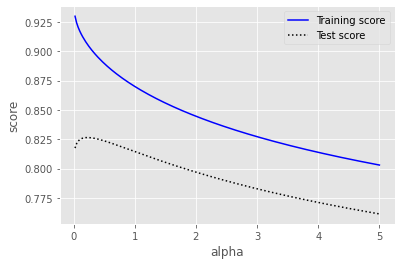

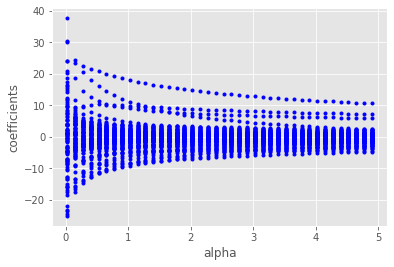

In [41]:
alpha_range      = np.linspace(0.025,5, 200)
train_scores = [] 
test_scores  = [] 
coefs       = []

for alpha in alpha_range:
    model = Ridge(alpha=alpha).fit(X_train, y_train)
    train_scores.append( model.score( X_train, y_train) )
    test_scores.append ( model.score( X_test,  y_test ) )
    coefs.append(model.coef_)

plot_ridge_result(alpha_range, train_scores, test_scores, coefs)

# Seems like this split yields much better result. Will study this further in future